# Policy Iteration, Sarsa and Q-learning
<b>Gabriele Prato, McGill University</b>

In this notebook, we will try the Policy Iteration, Sarsa and Q-learning algorithms on the Jack's Car Rental problem described in the class textbook [1].

Example 4.2 and Exercice 4.5 will be implemented as well as the Policy Iteration, Sarsa and Q-learning algorithm.

## Libraries and Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import random
from mpl_toolkits.mplot3d import axes3d

## Example 4.2: Jack's Car Rental

The following class is the Policy Iteration algorithm adapted for the Jack's Car Rental problem. We will use the same rules as in the book, except for the maximum number of cars per location, which we've lowered from 20 to 10. This change is recommended in the book to speed up computation, as 20 cars max takes a very long time. Everything else is exactly the same: costs, profit per car, expected rental requests and returns, etc.

In [2]:
class PolicyIteration:
    def __init__(self):
        self.policy = np.zeros((11, 11))
        self.values = np.zeros((11, 11))
    
    def viewPolicy(self):
        cmap = mpl.colors.ListedColormap(['#0000ff','#3333ff','#6666ff','#9999ff','#ccccff','#ffffff',
                                          '#ffcccc','#ff9999','#ff6666','#ff3333','#ff0000'])
        bounds=[-5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        img = plt.imshow(self.policy, interpolation='nearest', cmap = cmap, norm=norm, origin='lower')
        plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
        plt.xlabel('#Cars at second location')
        plt.ylabel('#Cars at first location')
        plt.show()
    
    def viewValues(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        X = np.zeros((11, 11))
        Y = np.zeros((11, 11))
        for i in range(11):
            for j in range(11):
                X[i, j] = i
                Y[i, j] = j

        ax.plot_wireframe(X, Y, self.values, rstride=10, cstride=10)
        ax.set_xlabel('#Cars at second location')
        ax.set_ylabel('#Cars at first location')

        plt.show()
    
    def trainForNIterations(self, N):
        iterationCount = 0
        policyStable = False
        while not policyStable:
            self.policyEvaluation()
            print('iteration: {} policy evaluation done'.format(iterationCount))
            policyStable = self.policyImprovement()
            print('iteration: {} policy improvement done'.format(iterationCount))
            iterationCount += 1
            if iterationCount == N:
                break
    
    def policyEvaluation(self):
        while True:
            delta = 0
            
            for s1 in range(11):
                for s2 in range(11):
                    v = self.values[s1, s2]
                    self.values[s1, s2] = self.estimateValue(s1, s2)
                    delta = max(delta, abs(v - self.values[s1, s2]))
            
            if delta < 0.1:
                break
    
    def estimateValue(self, s1, s2):
        carsMoved = self.policy[s1, s2]
        s1 -= int(carsMoved)
        s2 += int(carsMoved)
        
        value = carsMoved * -2.0
        
        for s1Prime in range(11):
            for numberOfCarsRented in range(max(0, s1 - s1Prime), s1 + 1):
                numberOfCarsReturned = s1Prime - s1 + numberOfCarsRented
                
                probability = (((3**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-3))
                    * ((3**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-3)))
                reward = numberOfCarsRented * 10
                
                value += probability * (reward + DISCOUNT * np.average(self.values, axis=1)[s1Prime])
        
        for s2Prime in range(11):
            for numberOfCarsRented in range(max(0, s2 - s2Prime), s2 + 1):
                numberOfCarsReturned = s2Prime - s2 + numberOfCarsRented
                
                probability = (((4**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-4))
                    * ((2**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-2)))
                reward = numberOfCarsRented * 10
                
                value += probability * (reward + DISCOUNT * np.average(self.values, axis=0)[s2Prime])
        
        return value

    def policyImprovement(self):
        policyStable = True
        
        for s1 in range(11):
            for s2 in range(11):
                oldAction = self.policy[s1, s2]
                self.policy[s1, s2] = self.maxValue(s1, s2)

                if self.policy[s1, s2] != oldAction:
                    policyStable = False
        
        return policyStable
    
    def maxValue(self, s1, s2):
        initialS1 = s1
        initialS2 = s2
        minMoveableCars = -min(s2, 10 - s1, 5)
        maxMoveableCars = min(s1, 10 - s2, 5)
        maxValue = np.NINF
        bestPolicy = 0
        for carsMoved in range(minMoveableCars, maxMoveableCars + 1):
            s1 = int(initialS1 - carsMoved)
            s2 = int(initialS2 + carsMoved)

            value = carsMoved * -2.0

            for s1Prime in range(11):
                for numberOfCarsRented in range(max(0, s1 - s1Prime), s1 + 1):
                    numberOfCarsReturned = s1Prime - s1 + numberOfCarsRented

                    probability = (((3**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-3))
                        * ((3**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-3)))
                    reward = numberOfCarsRented * 10

                    value += probability * (reward + DISCOUNT * np.average(self.values, axis=1)[s1Prime])

            for s2Prime in range(11):
                for numberOfCarsRented in range(max(0, s2 - s2Prime), s2 + 1):
                    numberOfCarsReturned = s2Prime - s2 + numberOfCarsRented

                    probability = (((4**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-4))
                        * ((2**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-2)))
                    reward = numberOfCarsRented * 10

                    value += probability * (reward + DISCOUNT * np.average(self.values, axis=0)[s2Prime])
            
            if value > maxValue:
                maxValue = value
                bestPolicy = carsMoved
        
        return bestPolicy

In [3]:
DISCOUNT = 0.8

iteration: 0 policy evaluation done
iteration: 0 policy improvement done
iteration: 1 policy evaluation done
iteration: 1 policy improvement done
iteration: 2 policy evaluation done
iteration: 2 policy improvement done


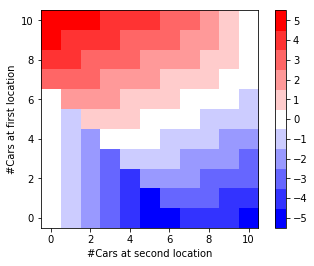

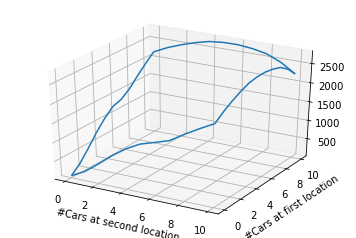

In [4]:
jackCarRental = PolicyIteration()
jackCarRental.trainForNIterations(5)
jackCarRental.viewPolicy()
jackCarRental.viewValues()

Results in the book [1]:
![bookResults](bookResults.png)

In the book, the shown results are for a maximum of 20 cars per location. Here we have results for a maximum of 10 cars per location. The learned optimal policy in both cases seems similar as we can see with the pattern in the graph we have here and in the book. Of course, since we've kept a number of 5 moveable cars per location but lowered the max number of cars per location to 10, the red and blue regions are closer to each other, there is less white region between them. With a maximum of 20 cars per location, the regions would be further apart like in the book.

The final state-value function is also very similar to the one in the book, except the range of our values is higher.

Now that we have a similar basis as in the book, we can now add new rules to see how they impact results.

## Exercice 4.5

We will implement the changes discussed in Exercice 4.5 to Jack's Car Rental problem and compare results with the ones we got previously in Example 4.2. Since we've lowered the maximum number of cars per location to 10, the new rule about max parking overnight will be lowered as well (from 10 to 5).

The changes are:<br/>
-The first car moved from location one to the second is free of charge.<br/>
-If more than 5 cars are kept overnight at a location (after any moving of cars), then an additional cost of 4$ must be incurred to use a second parking lot (independent of how many cars are kept there).

To better understand how these new rules affect the results, we will isolate each change, analyze results and finally combine them and analyze again results.

The first change is the free car:

In [6]:
class PolicyIterationFirstChange(PolicyIteration):
    def __init__(self):
        PolicyIteration.__init__(self)
    
    def estimateValue(self, s1, s2):
        carsMoved = self.policy[s1, s2]
        s1 -= int(carsMoved)
        s2 += int(carsMoved)
        
        value = carsMoved * -2.0
        if carsMoved > 0:
            value += 2.0
        
        for s1Prime in range(11):
            for numberOfCarsRented in range(max(0, s1 - s1Prime), s1 + 1):
                numberOfCarsReturned = s1Prime - s1 + numberOfCarsRented
                
                probability = (((3**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-3))
                    * ((3**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-3)))
                reward = numberOfCarsRented * 10
                
                value += probability * (reward + DISCOUNT * np.average(self.values, axis=1)[s1Prime])
        
        for s2Prime in range(11):
            for numberOfCarsRented in range(max(0, s2 - s2Prime), s2 + 1):
                numberOfCarsReturned = s2Prime - s2 + numberOfCarsRented
                
                probability = (((4**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-4))
                    * ((2**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-2)))
                reward = numberOfCarsRented * 10
                
                value += probability * (reward + DISCOUNT * np.average(self.values, axis=0)[s2Prime])
        
        return value
    
    def maxValue(self, s1, s2):
        initialS1 = s1
        initialS2 = s2
        minMoveableCars = -min(s2, 10 - s1, 5)
        maxMoveableCars = min(s1, 10 - s2, 5)
        maxValue = np.NINF
        bestPolicy = 0
        for carsMoved in range(minMoveableCars, maxMoveableCars + 1):
            s1 = int(initialS1 - carsMoved)
            s2 = int(initialS2 + carsMoved)

            value = carsMoved * -2.0
            if carsMoved > 0:
                value += 2.0  

            for s1Prime in range(11):
                for numberOfCarsRented in range(max(0, s1 - s1Prime), s1 + 1):
                    numberOfCarsReturned = s1Prime - s1 + numberOfCarsRented

                    probability = (((3**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-3))
                        * ((3**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-3)))
                    reward = numberOfCarsRented * 10

                    value += probability * (reward + DISCOUNT * np.average(self.values, axis=1)[s1Prime])

            for s2Prime in range(11):
                for numberOfCarsRented in range(max(0, s2 - s2Prime), s2 + 1):
                    numberOfCarsReturned = s2Prime - s2 + numberOfCarsRented

                    probability = (((4**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-4))
                        * ((2**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-2)))
                    reward = numberOfCarsRented * 10

                    value += probability * (reward + DISCOUNT * np.average(self.values, axis=0)[s2Prime])
            
            if value > maxValue:
                maxValue = value
                bestPolicy = carsMoved
        
        return bestPolicy

iteration: 0 policy evaluation done
iteration: 0 policy improvement done
iteration: 1 policy evaluation done
iteration: 1 policy improvement done
iteration: 2 policy evaluation done
iteration: 2 policy improvement done


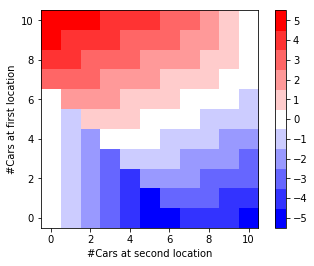

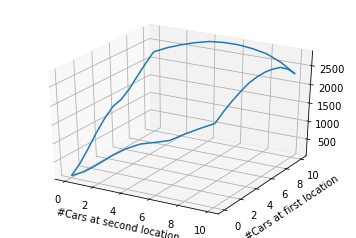

In [7]:
jackCarRental = PolicyIterationFirstChange()
jackCarRental.trainForNIterations(5)
jackCarRental.viewPolicy()
jackCarRental.viewValues()

For reference, here is are the results we got in the original problem:
![firstResults](firstResults.png)

As we can see, there doesn't seem to be any difference between the two. Maybe we could try increasing the number of free cars to 3:

In [8]:
class PolicyIterationFirstChange(PolicyIteration):
    def __init__(self):
        PolicyIteration.__init__(self)
    
    def estimateValue(self, s1, s2):
        carsMoved = self.policy[s1, s2]
        s1 -= int(carsMoved)
        s2 += int(carsMoved)
        
        value = max(0, carsMoved - 3) * -2.0
        
        for s1Prime in range(11):
            for numberOfCarsRented in range(max(0, s1 - s1Prime), s1 + 1):
                numberOfCarsReturned = s1Prime - s1 + numberOfCarsRented
                
                probability = (((3**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-3))
                    * ((3**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-3)))
                reward = numberOfCarsRented * 10
                
                value += probability * (reward + DISCOUNT * np.average(self.values, axis=1)[s1Prime])
        
        for s2Prime in range(11):
            for numberOfCarsRented in range(max(0, s2 - s2Prime), s2 + 1):
                numberOfCarsReturned = s2Prime - s2 + numberOfCarsRented
                
                probability = (((4**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-4))
                    * ((2**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-2)))
                reward = numberOfCarsRented * 10
                
                value += probability * (reward + DISCOUNT * np.average(self.values, axis=0)[s2Prime])
        
        return value
    
    def maxValue(self, s1, s2):
        initialS1 = s1
        initialS2 = s2
        minMoveableCars = -min(s2, 10 - s1, 5)
        maxMoveableCars = min(s1, 10 - s2, 5)
        maxValue = np.NINF
        bestPolicy = 0
        for carsMoved in range(minMoveableCars, maxMoveableCars + 1):
            s1 = int(initialS1 - carsMoved)
            s2 = int(initialS2 + carsMoved)

            value = max(0, carsMoved - 3) * -2.0 

            for s1Prime in range(11):
                for numberOfCarsRented in range(max(0, s1 - s1Prime), s1 + 1):
                    numberOfCarsReturned = s1Prime - s1 + numberOfCarsRented

                    probability = (((3**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-3))
                        * ((3**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-3)))
                    reward = numberOfCarsRented * 10

                    value += probability * (reward + DISCOUNT * np.average(self.values, axis=1)[s1Prime])

            for s2Prime in range(11):
                for numberOfCarsRented in range(max(0, s2 - s2Prime), s2 + 1):
                    numberOfCarsReturned = s2Prime - s2 + numberOfCarsRented

                    probability = (((4**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-4))
                        * ((2**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-2)))
                    reward = numberOfCarsRented * 10

                    value += probability * (reward + DISCOUNT * np.average(self.values, axis=0)[s2Prime])
            
            if value > maxValue:
                maxValue = value
                bestPolicy = carsMoved
        
        return bestPolicy

iteration: 0 policy evaluation done
iteration: 0 policy improvement done
iteration: 1 policy evaluation done
iteration: 1 policy improvement done
iteration: 2 policy evaluation done
iteration: 2 policy improvement done


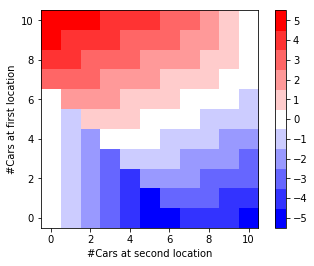

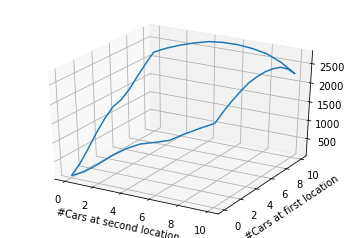

In [9]:
jackCarRental = PolicyIterationFirstChange()
jackCarRental.trainForNIterations(5)
jackCarRental.viewPolicy()
jackCarRental.viewValues()

Results original problem:
![firstResults](firstResults.png)

Again there doesn't seem to be any difference. This is probably due to the 2$ cost not affecting the value enough.

Now let's try the second change (extra parking costs) without the first change:

In [10]:
class PolicyIterationSecondChange(PolicyIteration):
    def __init__(self):
        PolicyIteration.__init__(self)
    
    def estimateValue(self, s1, s2):
        carsMoved = self.policy[s1, s2]
        s1 -= int(carsMoved)
        s2 += int(carsMoved)
        
        value = carsMoved * -2.0
        
        if s1 > 5:
            value -= 4
        if s2 > 5:
            value -= 4
        
        for s1Prime in range(11):
            for numberOfCarsRented in range(max(0, s1 - s1Prime), s1 + 1):
                numberOfCarsReturned = s1Prime - s1 + numberOfCarsRented
                
                probability = (((3**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-3))
                    * ((3**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-3)))
                reward = numberOfCarsRented * 10
                
                value += probability * (reward + DISCOUNT * np.average(self.values, axis=1)[s1Prime])
        
        for s2Prime in range(11):
            for numberOfCarsRented in range(max(0, s2 - s2Prime), s2 + 1):
                numberOfCarsReturned = s2Prime - s2 + numberOfCarsRented
                
                probability = (((4**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-4))
                    * ((2**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-2)))
                reward = numberOfCarsRented * 10
                
                value += probability * (reward + DISCOUNT * np.average(self.values, axis=0)[s2Prime])
        
        return value
    
    def maxValue(self, s1, s2):
        initialS1 = s1
        initialS2 = s2
        minMoveableCars = -min(s2, 10 - s1, 5)
        maxMoveableCars = min(s1, 10 - s2, 5)
        maxValue = np.NINF
        bestPolicy = 0
        for carsMoved in range(minMoveableCars, maxMoveableCars + 1):
            s1 = int(initialS1 - carsMoved)
            s2 = int(initialS2 + carsMoved)

            value = carsMoved * -2.0
            
            if s1 > 5:
                value -= 4
            if s2 > 5:
                value -= 4

            for s1Prime in range(11):
                for numberOfCarsRented in range(max(0, s1 - s1Prime), s1 + 1):
                    numberOfCarsReturned = s1Prime - s1 + numberOfCarsRented

                    probability = (((3**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-3))
                        * ((3**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-3)))
                    reward = numberOfCarsRented * 10

                    value += probability * (reward + DISCOUNT * np.average(self.values, axis=1)[s1Prime])

            for s2Prime in range(11):
                for numberOfCarsRented in range(max(0, s2 - s2Prime), s2 + 1):
                    numberOfCarsReturned = s2Prime - s2 + numberOfCarsRented

                    probability = (((4**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-4))
                        * ((2**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-2)))
                    reward = numberOfCarsRented * 10

                    value += probability * (reward + DISCOUNT * np.average(self.values, axis=0)[s2Prime])
            
            if value > maxValue:
                maxValue = value
                bestPolicy = carsMoved
        
        return bestPolicy

iteration: 0 policy evaluation done
iteration: 0 policy improvement done
iteration: 1 policy evaluation done
iteration: 1 policy improvement done
iteration: 2 policy evaluation done
iteration: 2 policy improvement done


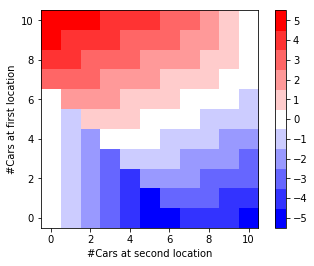

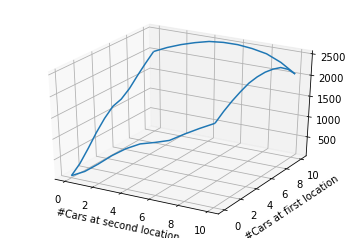

In [11]:
jackCarRental = PolicyIterationSecondChange()
jackCarRental.trainForNIterations(5)
jackCarRental.viewPolicy()
jackCarRental.viewValues()

Results original problem:
![firstResults](firstResults.png)

Again, there doesn't seem to be any difference. That may be caused by our higher valued values not being impacted by a single low cost of 4 dollars. Even in the original problem, it would be surprising that a backlash of 4 dollars would impact their values who range between 420 and 612 in the original problem. To make at least an impact, it would seem logical to increase the extra parking fee, to 40$ for example.

Let's try that:

In [12]:
class PolicyIterationSecondChange(PolicyIteration):
    def __init__(self):
        PolicyIteration.__init__(self)
    
    def estimateValue(self, s1, s2):
        carsMoved = self.policy[s1, s2]
        s1 -= int(carsMoved)
        s2 += int(carsMoved)
        
        value = carsMoved * -2.0
        
        if s1 > 5:
            value -= 40
        if s2 > 5:
            value -= 40
        
        for s1Prime in range(11):
            for numberOfCarsRented in range(max(0, s1 - s1Prime), s1 + 1):
                numberOfCarsReturned = s1Prime - s1 + numberOfCarsRented
                
                probability = (((3**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-3))
                    * ((3**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-3)))
                reward = numberOfCarsRented * 10
                
                value += probability * (reward + DISCOUNT * np.average(self.values, axis=1)[s1Prime])
        
        for s2Prime in range(11):
            for numberOfCarsRented in range(max(0, s2 - s2Prime), s2 + 1):
                numberOfCarsReturned = s2Prime - s2 + numberOfCarsRented
                
                probability = (((4**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-4))
                    * ((2**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-2)))
                reward = numberOfCarsRented * 10
                
                value += probability * (reward + DISCOUNT * np.average(self.values, axis=0)[s2Prime])
        
        return value
    
    def maxValue(self, s1, s2):
        initialS1 = s1
        initialS2 = s2
        minMoveableCars = -min(s2, 10 - s1, 5)
        maxMoveableCars = min(s1, 10 - s2, 5)
        maxValue = np.NINF
        bestPolicy = 0
        for carsMoved in range(minMoveableCars, maxMoveableCars + 1):
            s1 = int(initialS1 - carsMoved)
            s2 = int(initialS2 + carsMoved)

            value = carsMoved * -2.0
            
            if s1 > 5:
                value -= 40
            if s2 > 5:
                value -= 40

            for s1Prime in range(11):
                for numberOfCarsRented in range(max(0, s1 - s1Prime), s1 + 1):
                    numberOfCarsReturned = s1Prime - s1 + numberOfCarsRented

                    probability = (((3**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-3))
                        * ((3**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-3)))
                    reward = numberOfCarsRented * 10

                    value += probability * (reward + DISCOUNT * np.average(self.values, axis=1)[s1Prime])

            for s2Prime in range(11):
                for numberOfCarsRented in range(max(0, s2 - s2Prime), s2 + 1):
                    numberOfCarsReturned = s2Prime - s2 + numberOfCarsRented

                    probability = (((4**numberOfCarsRented / math.factorial(numberOfCarsRented)) * np.exp(-4))
                        * ((2**numberOfCarsReturned / math.factorial(numberOfCarsReturned)) * np.exp(-2)))
                    reward = numberOfCarsRented * 10

                    value += probability * (reward + DISCOUNT * np.average(self.values, axis=0)[s2Prime])
            
            if value > maxValue:
                maxValue = value
                bestPolicy = carsMoved
        
        return bestPolicy

iteration: 0 policy evaluation done
iteration: 0 policy improvement done
iteration: 1 policy evaluation done
iteration: 1 policy improvement done
iteration: 2 policy evaluation done
iteration: 2 policy improvement done
iteration: 3 policy evaluation done
iteration: 3 policy improvement done


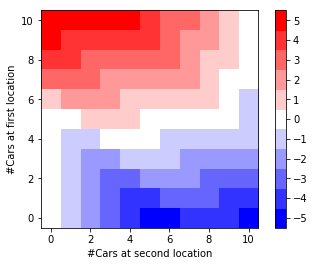

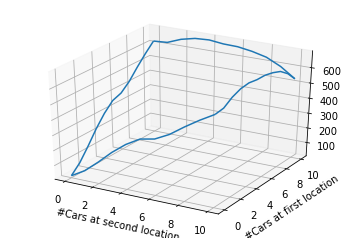

In [13]:
jackCarRental = PolicyIterationSecondChange()
jackCarRental.trainForNIterations(5)
jackCarRental.viewPolicy()
jackCarRental.viewValues()

Results original problem:
![firstResults](firstResults.png)

The red region seems to be more dominant when the first location is full. The policy seems to want to move more cars from the first to the second when the first is fuller and the second emptier. This is not surprising as its a good way of keeping costs down.

The blue region seems to have changed slightly differently then the red. It seems like when the second region is full and the first is halfway full, the policy moves cars from the second to the first. Unlike the changes with the red region, the policy doesn't seem to have changed its policy when the second location is full and the first has very few cars or is empty.

The value also seems to have increased when one location is full and the other is empty or almost.
<br/><br/>

Since the first rule didn't affect results, we will not try both changes at the same time, as this would be pointless (I did try and the first rule didn't impact results we go with the second rule).

## TD methods

We will now implement Sarsa and Q-learning on the Jack's Car Rental problem and compare results with the ones we got with Policy Iteration.

To do this, we must create an Environment class to allow Sarsa and Q-learning to generate episodes of the Jack's Car Rental problem:

In [14]:
class Environment:
    def __init__(self):
        self.state = np.array([np.random.randint(11, size=1)[0],
                               np.random.randint(11, size=1)[0]])
    
    def reset(self):
        self.state = np.array([np.random.randint(11, size=1)[0],
                               np.random.randint(11, size=1)[0]])
    
    def takeAction(self, action):
        self.state[0] -= action
        self.state[1] += action
        
        reward = action * -2.0
        
        numberOfCarsRentedLoc1 = self.state[0] + 1
        while numberOfCarsRentedLoc1 > self.state[0]:
            numberOfCarsRentedLoc1 = max(0, np.random.poisson(3, 1)[0])
            
        numberOfCarsRentedLoc2 = self.state[1] + 1
        while numberOfCarsRentedLoc2 > self.state[1]:
            numberOfCarsRentedLoc2 = max(0, np.random.poisson(4, 1)[0])
            
        self.state[0] -= numberOfCarsRentedLoc1
        self.state[1] -= numberOfCarsRentedLoc2
        
        self.state[0] = min(10, self.state[0] + np.random.poisson(3, 1)[0])
        self.state[1] = min(10, self.state[1] + np.random.poisson(2, 1)[0])
        
        reward += numberOfCarsRentedLoc1 * 10 +  numberOfCarsRentedLoc2 * 10
        return reward

In [15]:
class Sarsa:
    def __init__(self, environment):
        self.Q = np.zeros((11, 11, 11))
        self.environment = environment
    
    def resetQ(self):
        self.Q = np.zeros((11, 11, 11))
    
    def chooseAction(self):
        maxLocation1CanGet = min(5, 10 - self.environment.state[0])
        maxLocation2CanGet = min(5, 10 - self.environment.state[1])
        maxLocation1CanMove = min(5, self.environment.state[0])
        maxLocation2CanMove = min(5, self.environment.state[1])
        maxLocation1To2 = min(maxLocation1CanMove, maxLocation2CanGet)
        maxLocation2To1 = min(maxLocation2CanMove, maxLocation1CanGet)
        actionRange = maxLocation1To2 + maxLocation2To1 + 1
        rangeLowerBound = 5 - maxLocation2To1
        rangeUpperBound = 5 + maxLocation1To2
        
        if np.random.rand(1)[0] <= EPSILON:
            actionId = np.random.randint(actionRange, size=1)[0] + rangeLowerBound
        else:
            actionId = np.argmax(self.Q[self.environment.state[0], self.environment.state[1], 
                                        rangeLowerBound : rangeUpperBound + 1]) + rangeLowerBound
            
            # If multiple actions have the same max value, we need to choose one of them randomly
            possibleActions = []
            for i in range(actionRange):
                if (self.Q[self.environment.state[0], self.environment.state[1], i + rangeLowerBound]
                    == self.Q[self.environment.state[0], self.environment.state[1], actionId]
                   ):
                    possibleActions.append(i + rangeLowerBound)
                    
            actionId = random.choice(possibleActions)
        
        return actionId
    
    def runForNTimeSteps(self, N):
        self.environment.reset()
        
        reward = 0
        
        actionId = self.chooseAction()

        for i in range(N):
            previousState = np.copy(self.environment.state)
            
            reward = self.environment.takeAction(actionId - 5)
            
            nextActionId = self.chooseAction()
        
            self.Q[previousState[0], previousState[1], actionId] += ALPHA * (reward + 
                DISCOUNT * self.Q[self.environment.state[0], self.environment.state[1], nextActionId] - 
                self.Q[previousState[0], previousState[1], actionId])
            
            actionId = nextActionId
    
    def viewPolicy(self):
        policy = np.zeros((11, 11))
        for i in range(11):
            for j in range(11):
                policy[i, j] = np.argmax(self.Q[i, j]) - 5
        
        cmap = mpl.colors.ListedColormap(['#0000ff','#3333ff','#6666ff','#9999ff','#ccccff','#ffffff',
                                          '#ffcccc','#ff9999','#ff6666','#ff3333','#ff0000'])
        bounds=[-5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        img = plt.imshow(policy, interpolation='nearest', cmap = cmap, norm=norm, origin='lower')
        plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
        plt.xlabel('#Cars at second location')
        plt.ylabel('#Cars at first location')
        plt.show()
    
    def viewValues(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        X = np.zeros((11, 11))
        Y = np.zeros((11, 11))
        for i in range(11):
            for j in range(11):
                X[i, j] = i
                Y[i, j] = j
        
        values = np.zeros((11, 11))
        for i in range(11):
            for j in range(11):
                values[i, j] = np.max(self.Q[i, j])

        ax.plot_wireframe(X, Y, values, rstride=10, cstride=10)

        plt.show()

The Qlearning class will be exactly like the Sarsa class, except for the change in its core algorithm.

In [16]:
class Qlearning(Sarsa):
    def __init__(self, environment):
        Sarsa.__init__(self, environment)
    
    def runForNTimeSteps(self, N):
        self.environment.reset()
        
        reward = 0

        for i in range(N):
            previousState = np.copy(self.environment.state)
            
            actionId = self.chooseAction()
            reward = self.environment.takeAction(actionId - 5)
        
            self.Q[previousState[0], previousState[1], actionId] += ALPHA * (reward + 
                DISCOUNT * np.max(self.Q[self.environment.state[0], self.environment.state[1]]) - 
                self.Q[previousState[0], previousState[1], actionId])

Let's start with Sarsa:

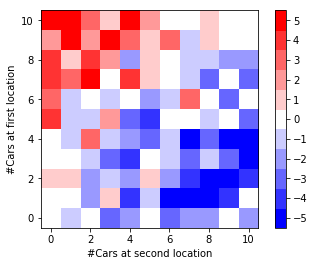

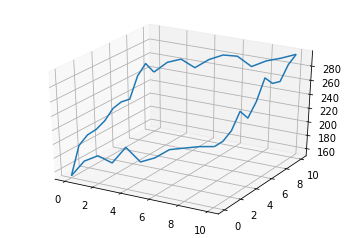

In [17]:
ALPHA = 0.5
EPSILON = 0.1

jackCarRental = Environment()
sarsa = Sarsa(jackCarRental)
sarsa.runForNTimeSteps(100000)
sarsa.viewPolicy()
sarsa.viewValues()

Results original problem:
![firstResults](firstResults.png)

The red and blue regions aren't as good as with Policy Iteration. The value seems to be better, shaping similarly to the results we got with Policy Iteration.

<b>Note that I tried averaging results, but the value plan flattened to much and the red and blue regions didn't improve much. I also tried more iterations, but results didn't improve.</b>

Now let's see what we get with Q-learning:

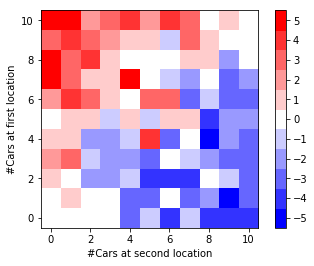

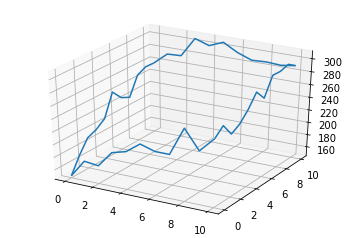

In [18]:
jackCarRental = Environment()
ql = Qlearning(jackCarRental)
ql.runForNTimeSteps(100000)
ql.viewPolicy()
ql.viewValues()

Results original problem:
![firstResults](firstResults.png)

Results are similar to the ones we got with Sarsa. Value looks best and regions are poorly defined.

Randomness affects results, so feel free to re-run the Sarsa and Q-learning cells. The patterns in the results don't change much though.

## Conclusion

We've implemented and compared the Policy Iteration, Sarsa and Q-learning algorithms on the Jack's Car Rental problem found in the class textbook [1].

The results obtained by Sarsa and Q-learning were slightly poorer than the ones we got from Policy Iteration. With Sarsa and Q-learning, the red and blue regions were not as well defined as with Policy Iteration. Value was more similar though for Sarsa and Q-learning in comparison to Policy Iteration.

All in all, Policy Iteration performed better. The algorithm is more heavy computation wise, but gets good results in this case.

It would be interesting to try Policy Iteration on more environments and see when it becomes too hungry computation wise for problems of different complexities.

It would also be interesting to try more algorithms on the Jack's Car Rental problem and maybe modify a couple of rules to see how they impact results, as the changes we've made didn't impact results too much.

## References

[1] <a href="https://webdocs.cs.ualberta.ca/~sutton/book/the-book-2nd.html">Richard S. Sutton and Andrew G. Barto, "Reinforcement learning: An introduction", Second Edition, MIT Press</a>, in preparation<br />

Jack's Car Rental problem and the Policy Iteration algorithm can be found on page 87.<br/>
The Sarsa and Q-learning algorithms can be found on page 138 and 140.